# 直方图与傅里叶变换

**cv2.calcHist(images, channels, mask, histSize, ranges)**
- images: 原图像图像格式为uint8或float32, 当传入函数时应用中括号[ ]来传入，例如[img]
- channels: 同样用中括号来传入；如果输入图像是灰度图像，那它的值就是[0]；如果输入图像是彩色图像，那它的值可以是[0][1][2]，分别代表BGR
- mask: 掩模图像。如果统计整幅图像的直方图，那它的值就死None；如果只是要统计某一部分的直方图，那就要制作相应的掩模图像。
- histSize: BIN的数目，也用中括号[ ]来传入
- ranges: 像素值范围常为[0, 255]

In [3]:
# 导入库
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [10]:
# 导入图像
img = cv2.imread('images_for_note/cat.jpg', cv2.IMREAD_GRAYSCALE)
hist = cv2.calcHist([img], [0], None, [256], [0, 255])
hist.shape

(256, 1)

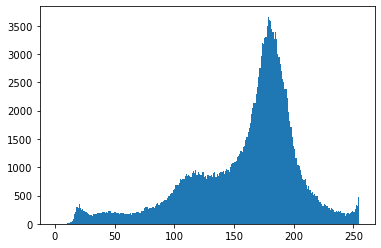

In [11]:
plt.hist(img.ravel(), 256)
plt.show()

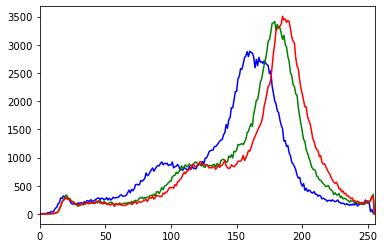

In [20]:
img = cv2.imread('images_for_note/cat.jpg')
color = ('b', 'g', 'r')
for i, col in enumerate(color):
    histr = cv2.calcHist([img], [i], None, [256], [0, 255])
    plt.plot(histr, color=col)
    plt.xlim([0, 255])

## mask操作

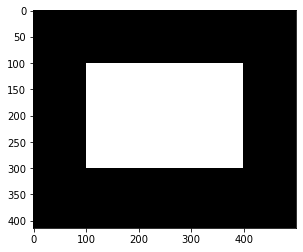

In [15]:
# 创建掩模
mask = np.zeros(img.shape[:2], np.uint8)
mask[100:300, 100:400] = 255
plt.imshow(mask, cmap='gray')

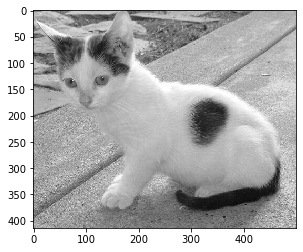

In [25]:
img = cv2.imread('images_for_note/cat.jpg', 0)
plt.imshow(img, cmap='gray')

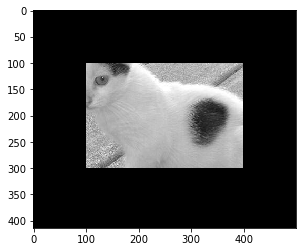

In [27]:
mask_img = cv2.bitwise_and(img, img, mask=mask)
plt.imshow(mask_img, cmap='gray')

In [28]:
# 计算直方图
hist_full = cv2.calcHist([img], [0], None, [256], [0, 255])
hist_mask = cv2.calcHist([img], [0], mask, [256], [0, 255])

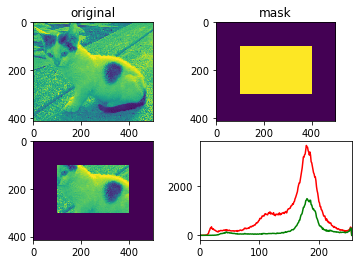

In [32]:
plt.subplot(221), plt.imshow(img), plt.title('original')
plt.subplot(222), plt.imshow(mask), plt.title('mask')
plt.subplot(223), plt.imshow(mask_img)
plt.subplot(224), plt.plot(hist_full, color='r'), plt.plot(hist_mask, color='g')
plt.xlim([0, 255])
plt.show()

## 直方图均衡化
**cv2.equalizeHist**

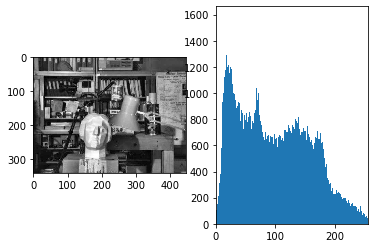

In [44]:
# 对灰度图进行直方图均衡化，读取图像时参数为0表示灰度图像
img = cv2.imread('images_for_note/clahe.jpg', 0)
plt.subplot(121), plt.imshow(img, cmap='gray')
plt.subplot(122), plt.hist(img.ravel(), 256)
plt.xlim([0, 256])
plt.show()

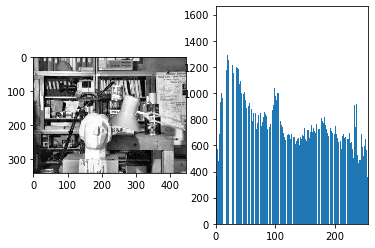

In [45]:
res = cv2.equalizeHist(img)
plt.subplot(121), plt.imshow(res, cmap='gray')
plt.subplot(122), plt.hist(res.ravel(), 256)
plt.xlim([0, 256])
plt.show()

> 注意到一个问题，对整幅图像进行全局的直方图均衡化，容易丢失一些细节信息，因此产生一个思路：对于图像中不同区域执行各自的直方图均衡化，效果应该会比全局均衡化更好（但是局部均衡化对于噪声的抗性会变差）

## 自适应直方图均衡化

In [43]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

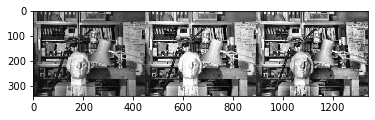

In [47]:
res_clahe = clahe.apply(img)
result = np.hstack((img, res, res_clahe))
plt.imshow(result, cmap='gray')

## 傅里叶变换
### 傅里叶变换的作用
- 高频：变化剧烈的灰度分量（如边界）
- 低频：变化缓慢的灰度分量（如一张平面）
### 滤波
- 低通滤波器：只保留低频，会使得图像模糊
- 高通滤波器：只保留高频，会使得图像细节增强

- opencv中主要使用的函数是`cv2.dft( )`和`cv2.idft( )`, **输入图像需要先转换成np.float32的格式**
- 得到的结果中频率为0的部分往往会出现在左上角，通常要转换到中心位置，可以通过shift变换来实现
- cv2.dift( )返回的结果是双通道的（实部、虚部），通常还需要转换成图像格式才能展示(0, 255)

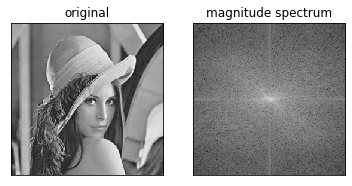

In [51]:
img_lena = cv2.imread('lena.jpg', 0)
# 转换格式为np.float32
img_float32 = np.float32(img_lena)

# DFT
dft = cv2.dft(img_float32, flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

# 得到灰度图能表示的形式，映射公式
magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))
# 显示效果图
plt.subplot(121), plt.imshow(img_lena, cmap='gray')
plt.title('original'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('magnitude spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

> 越靠近中心位置，频率越低；呈发散式

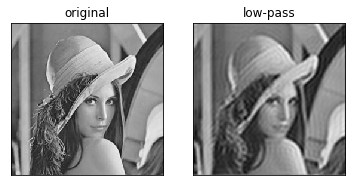

In [57]:
rows, cols = img_lena.shape
# 计算中心位置
crow, ccol = int(rows/2), int(cols/2)

# 低通滤波
mask = np.zeros((rows, cols, 2), np.uint8)
mask[crow-30:crow+30, ccol-30:ccol+30] = 1

#IDFT
idft = dft_shift * mask
f_idft = np.fft.ifftshift(idft) # 将频率为0的部分位置还原
img_back = cv2.idft(f_idft)
# 此时仍需要处理实部和虚部
img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

# 显示效果图，显然低通滤波器使图像变得更加模糊了
plt.subplot(121), plt.imshow(img_lena, cmap='gray')
plt.title('original'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_back, cmap='gray')
plt.title('low-pass'), plt.xticks([]), plt.yticks([])
plt.show()

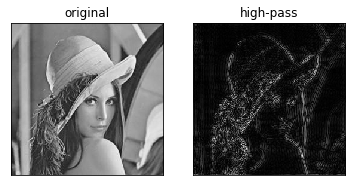

In [58]:
# 高通滤波器
rows, cols = img_lena.shape
# 计算中心位置
crow, ccol = int(rows/2), int(cols/2)

# 低通滤波
mask = np.ones((rows, cols, 2), np.uint8)
mask[crow-30:crow+30, ccol-30:ccol+30] = 0

#IDFT
idft = dft_shift * mask
f_idft = np.fft.ifftshift(idft) # 将频率为0的部分位置还原
img_back = cv2.idft(f_idft)
# 此时仍需要处理实部和虚部
img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

# 显示效果图，显然高通滤波器后得到了边界信息
plt.subplot(121), plt.imshow(img_lena, cmap='gray')
plt.title('original'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_back, cmap='gray')
plt.title('high-pass'), plt.xticks([]), plt.yticks([])
plt.show()